In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
df = (pd.read_csv(filepath_or_buffer='/Users/nilkanthpatel/Desktop/SPRING 2024/Data Analytics/project 3/histretSP.csv', index_col='Year')).fillna(0)

In [3]:
df.describe()

,S&P 500,T-Bill,T-Bond,Baa Bond,Real Estate,Gold
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000
mean,0.116578,0.033385,0.048587,0.069537,0.044181,0.065542
std,0.195508,0.030075,0.079517,0.077123,0.062416,0.207722
min,-0.438375,0.000327,-0.178282,-0.156808,-0.119956,-0.325986
25%,-0.011935,0.008508,0.008063,0.023922,0.009206,-0.005910
50%,0.145211,0.029350,0.032822,0.063554,0.038540,0.000969
75%,0.259666,0.050642,0.085448,0.113901,0.075237,0.137430
max,0.525633,0.140362,0.328145,0.290525,0.241017,1.265487


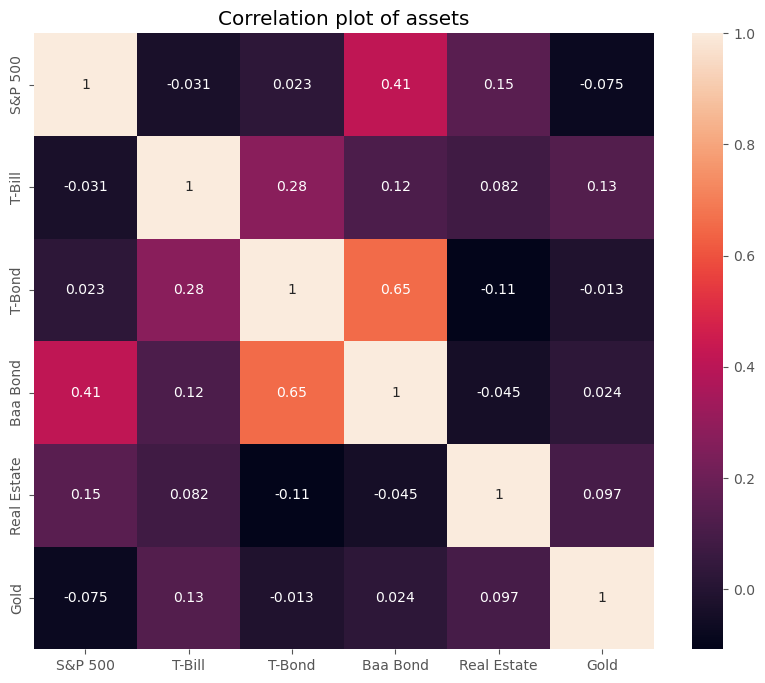

In [4]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(),annot=True)
plt.title('Correlation plot of assets')
plt.show()

In [5]:
# 1.	All-equity portfolio
portfolios = pd.DataFrame() 
portfolios['All Equity portfolio'] = df['S&P 500']


In [6]:
# 2.	Traditional 60/40 portfolio, which became common in 1926 and consists of the following:

portfolios['Traditional 60/40'] = 0.60*df['S&P 500'] + 0.4*df['T-Bond']

In [7]:
# 3 Harry Browne’s permanent portfolio, which he proposed in about 1980 and consists of the following:
#   1. 25% equity
#   2. 25% long-term Treasury bonds
#   3. 25% Treasury bills (i.e., cash)
#   4. 25% gold

portfolios['Harry Browne portfolio'] = df[['S&P 500', 'T-Bond','T-Bill','Gold']].sum(axis=1).div(4)

In [8]:
# 4. Ray Dalio’s all seasons portfolio, which he proposed in about 2014 and consists of the following:
#   1. 30% equity
#   2. 40% long-term Treasury bonds
#   3. 15% intermediate Treasury bonds
#   4. 7.5% commodities
#   5. 7.5% gold

colums = ['S&P 500', 'T-Bond','Gold']
weights = [0.30,0.55,0.15,]
portfolios['Ray Dalio portfolio'] = 0
for i in range(len(weights)):
    portfolios['Ray Dalio portfolio'] = portfolios['Ray Dalio portfolio'] + (df[colums[i]]*weights[i])

In [9]:
# 5. Another portfolio that build from the asset class returns

def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.dot(mean_returns, weights)
    std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return std_dev, returns

def portfolios_simulation(iterations, mean_returns, cov_matrix, risk_free_rate):
    assets = len(mean_returns)
    results = np.zeros((3, iterations))
    weights_df = np.zeros((iterations, assets))
    for i in range(iterations):
        weights = np.random.random(assets)
        weights /= np.sum(weights)
        weights_df[i] = weights
        portfolio_std_dev, portfolio_return = portfolio_performance(weights, mean_returns, cov_matrix)
        results[0, i] = portfolio_std_dev
        results[1, i] = portfolio_return
        results[2, i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_df

def portfolio_selection(mean_returns, cov_matrix, iterations, risk_free_rate):
    results, weights = portfolios_simulation(iterations, mean_returns, cov_matrix, risk_free_rate)
    max_sharpe = np.argmax(results[2])
    max_sharpe_weights = pd.DataFrame(weights[max_sharpe], index=mean_returns.index, columns=['allocation'])
    max_sharpe_weights['allocation'] = (max_sharpe_weights['allocation'] * 100).round(2)
    min_vol = np.argmin(results[0])
    min_vol_weights = pd.DataFrame(weights[min_vol], index=mean_returns.index, columns=['allocation'])
    min_vol_weights['allocation'] = (min_vol_weights['allocation'] * 100).round(2)
    return max_sharpe_weights,min_vol_weights

In [10]:
mean_returns = df.mean()
cov_matrix = df.cov()
iterations = 100000
risk_free_rate = df['T-Bond'].mean()

weights1 , weights2 = portfolio_selection(mean_returns, cov_matrix, iterations, risk_free_rate)


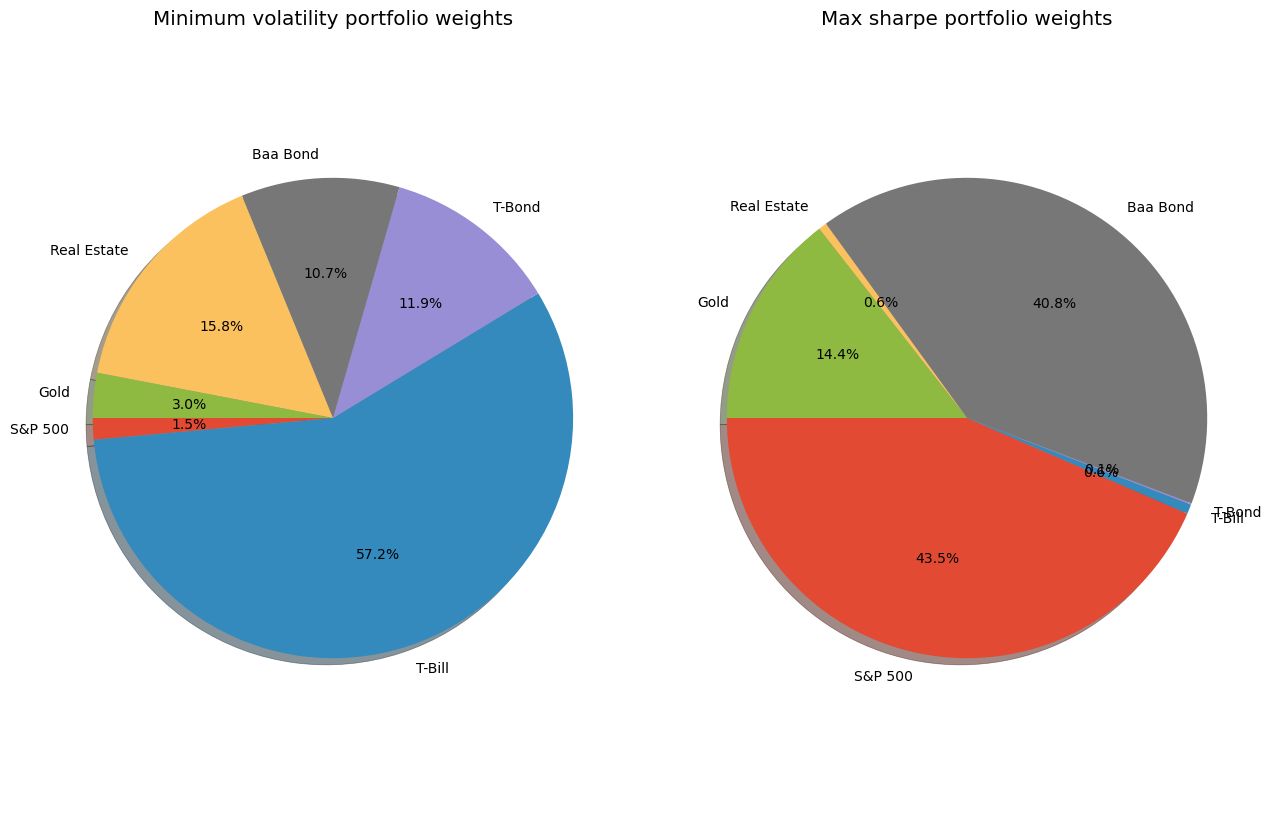

In [11]:
plt.figure(figsize=(15,10))
plt.subplot(121)
plt.pie(weights2['allocation'],labels=df.columns.to_list(),shadow=True,autopct='%1.1f%%',startangle=180)
plt.title('Minimum volatility portfolio weights')
plt.axis('equal')
plt.subplot(122)
plt.pie(weights1['allocation'],labels=df.columns.to_list(),shadow=True,autopct='%1.1f%%',startangle=180)
plt.title('Max sharpe portfolio weights')
plt.axis('equal')
plt.show()

In [29]:
portfolios['Mean Variance portfolio'] = np.dot(df,weights2/100)


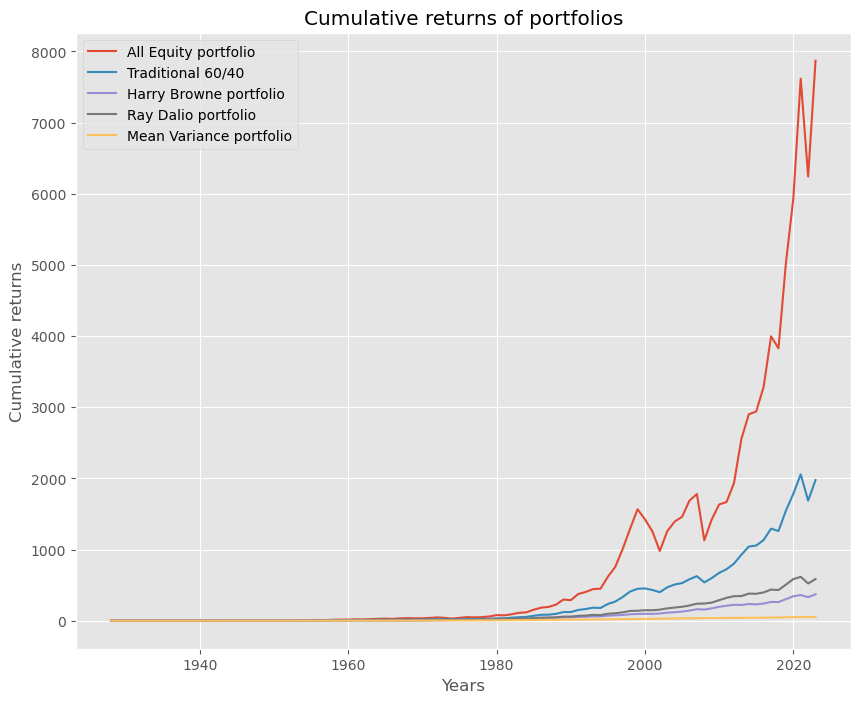

In [30]:
plt.figure(figsize=(10,8))
plt.style.use('ggplot')
plt.plot((1+portfolios).cumprod(),label = portfolios.columns.to_list())
plt.grid(True)
plt.title('Cumulative returns of portfolios')
plt.ylabel('Cumulative returns')
plt.xlabel('Years')
plt.legend()
plt.show()

In [14]:
summary_stat =  portfolios.describe()
rf =  df['T-Bill'].mean()
summary_stat.loc['sharpe'] = (summary_stat.iloc[1]-rf)/summary_stat.iloc[2]
summary_stat.loc['kurtosis'] = portfolios.kurtosis()
summary_stat.loc['skewness'] = portfolios.skew()


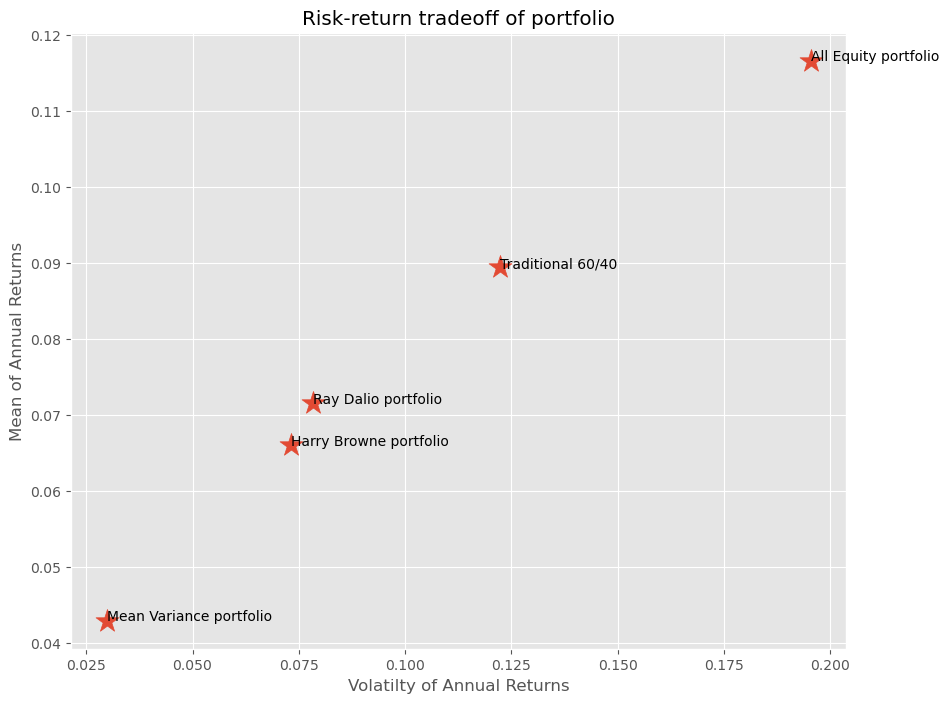

In [15]:

plt.figure(figsize=(10,8))
plt.scatter(summary_stat.iloc[2],summary_stat.iloc[1],marker = '*', s = 300)
for i, txt in enumerate(summary_stat.columns):
    plt.annotate(txt, (summary_stat.iloc[2, i], summary_stat.iloc[1, i]))
plt.xlabel('Volatilty of Annual Returns')
plt.ylabel('Mean of Annual Returns')
plt.title('Risk-return tradeoff of portfolio')
plt.show()


Text(0.5, 1.0, 'Krenal density plot of portfolios')

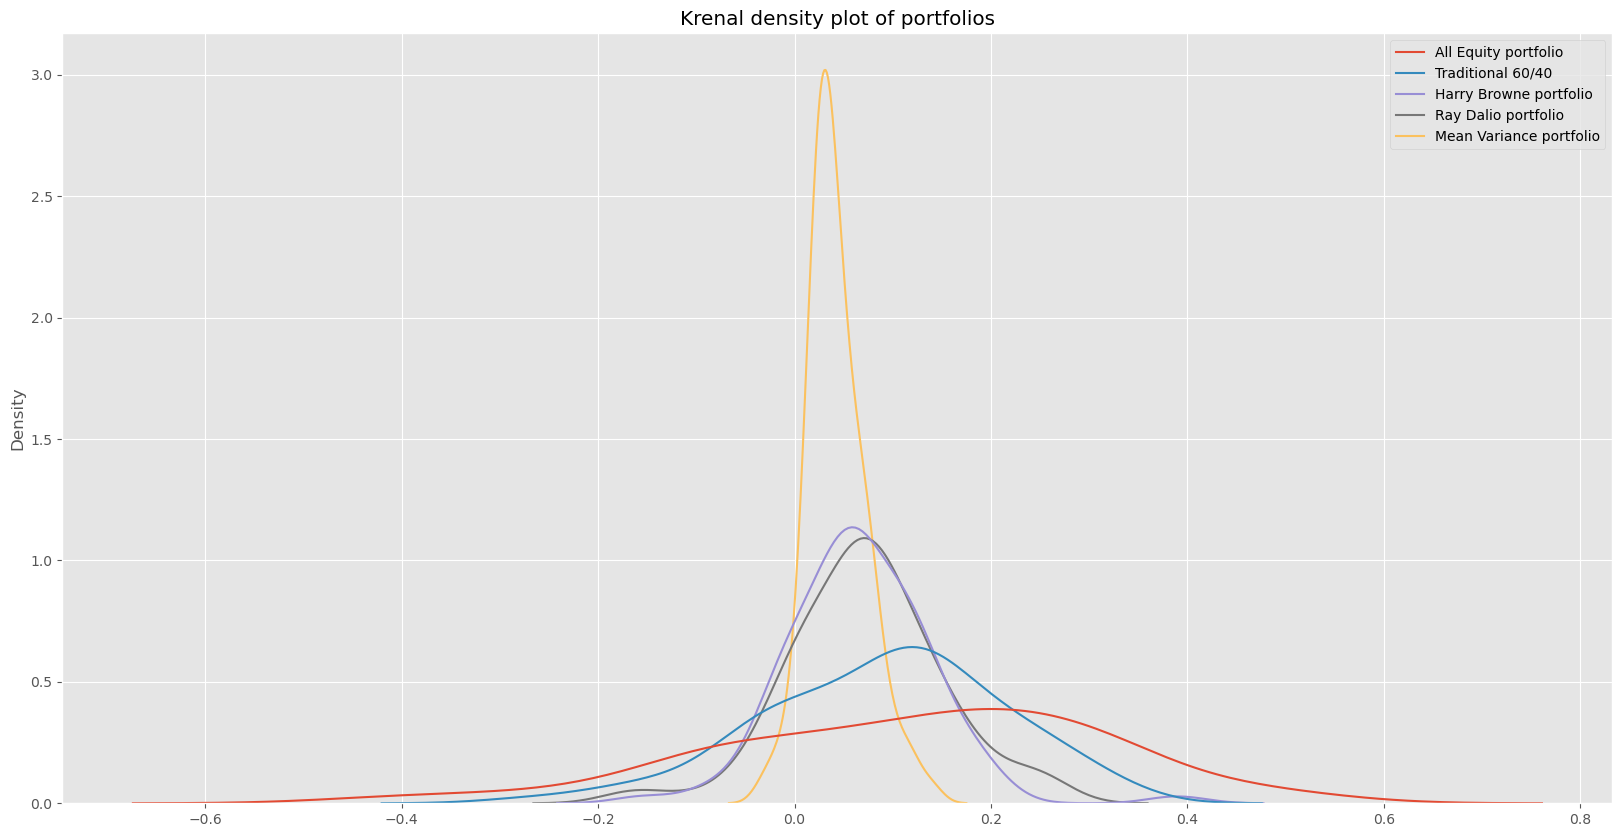

In [16]:
plt.figure(figsize=(20,10))
sns.kdeplot(portfolios)
plt.title('Krenal density plot of portfolios')

In [17]:

def efficient_frontiers(mean_returns, cov_matrix, iterations, risk_free_rate):
    results, _ = portfolios_simulation(iterations, mean_returns, cov_matrix, risk_free_rate)

    max_sharpe = np.argmax(results[2])
    sigma_S, ret_S = results[0][max_sharpe], results[1][max_sharpe]
    r = results[1,np.argmax(results[2])]

    min_vol = np.argmin(results[0])
    sigma_min, ret_min = results[0][min_vol], results[1][min_vol]

    cml_x = np.linspace(0,max(results[0]), num=100)
    cml_y = risk_free_rate + (r-risk_free_rate) / sigma_S * cml_x
    plt.figure(figsize=(20, 10))
    plt.scatter(results[0], results[1], c=results[2], cmap='magma', marker='o')
    plt.colorbar()
    plt.scatter(sigma_S, ret_S, marker='*', color='r', s=500, label='Maximum Sharpe ratio')
    plt.scatter(sigma_min, ret_min, marker='*', color='g', s=500, label='Minimum volatility')
    plt.plot(cml_x,cml_y,label = 'Capital market line')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('Annual Volatility')
    plt.ylabel('Annual Returns')
    plt.legend(labelspacing=0.8)
    

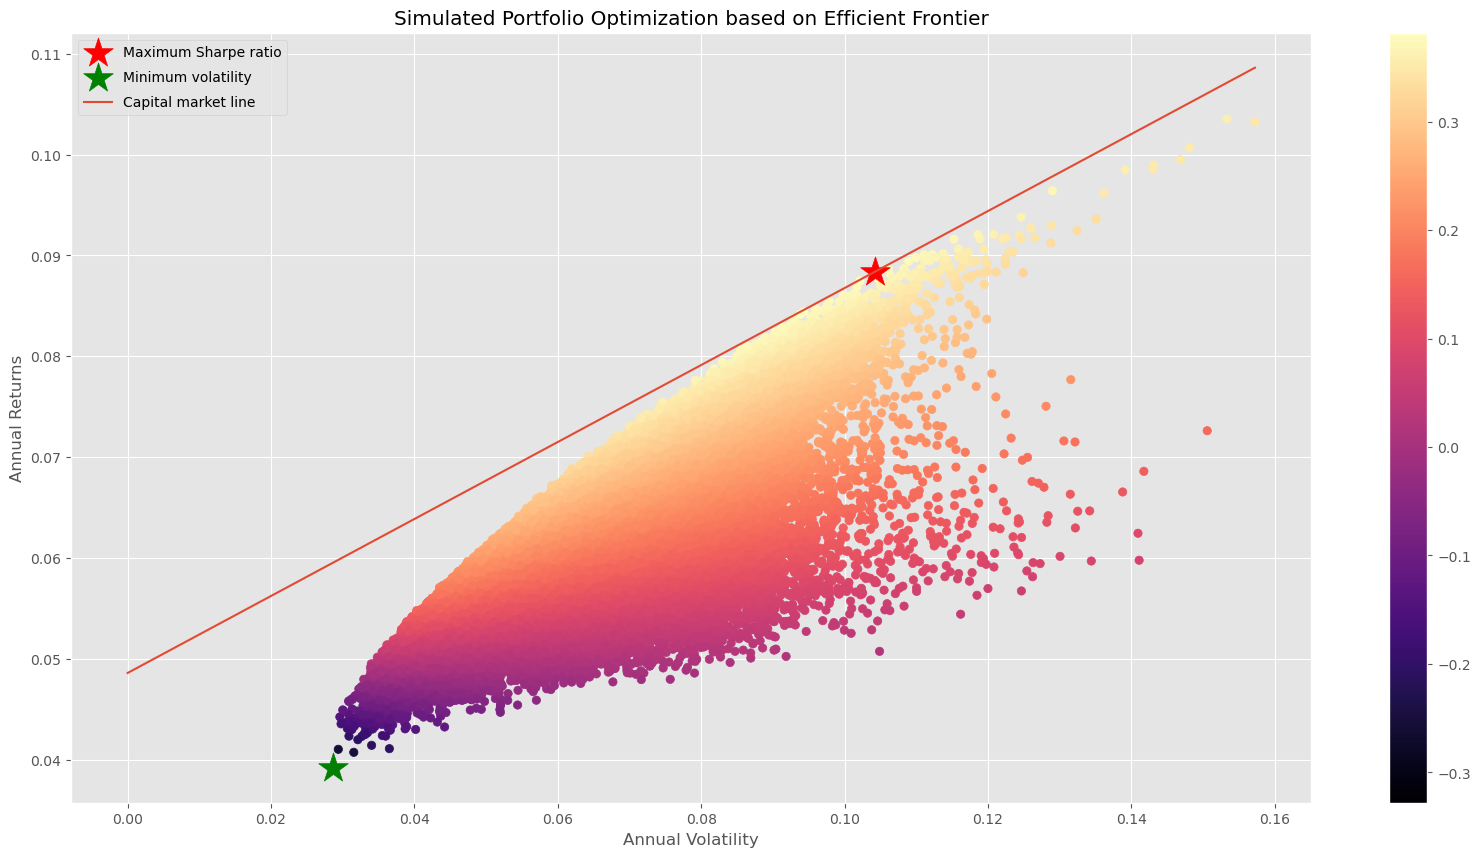

In [18]:
efficient_frontiers(mean_returns, cov_matrix, iterations, risk_free_rate)

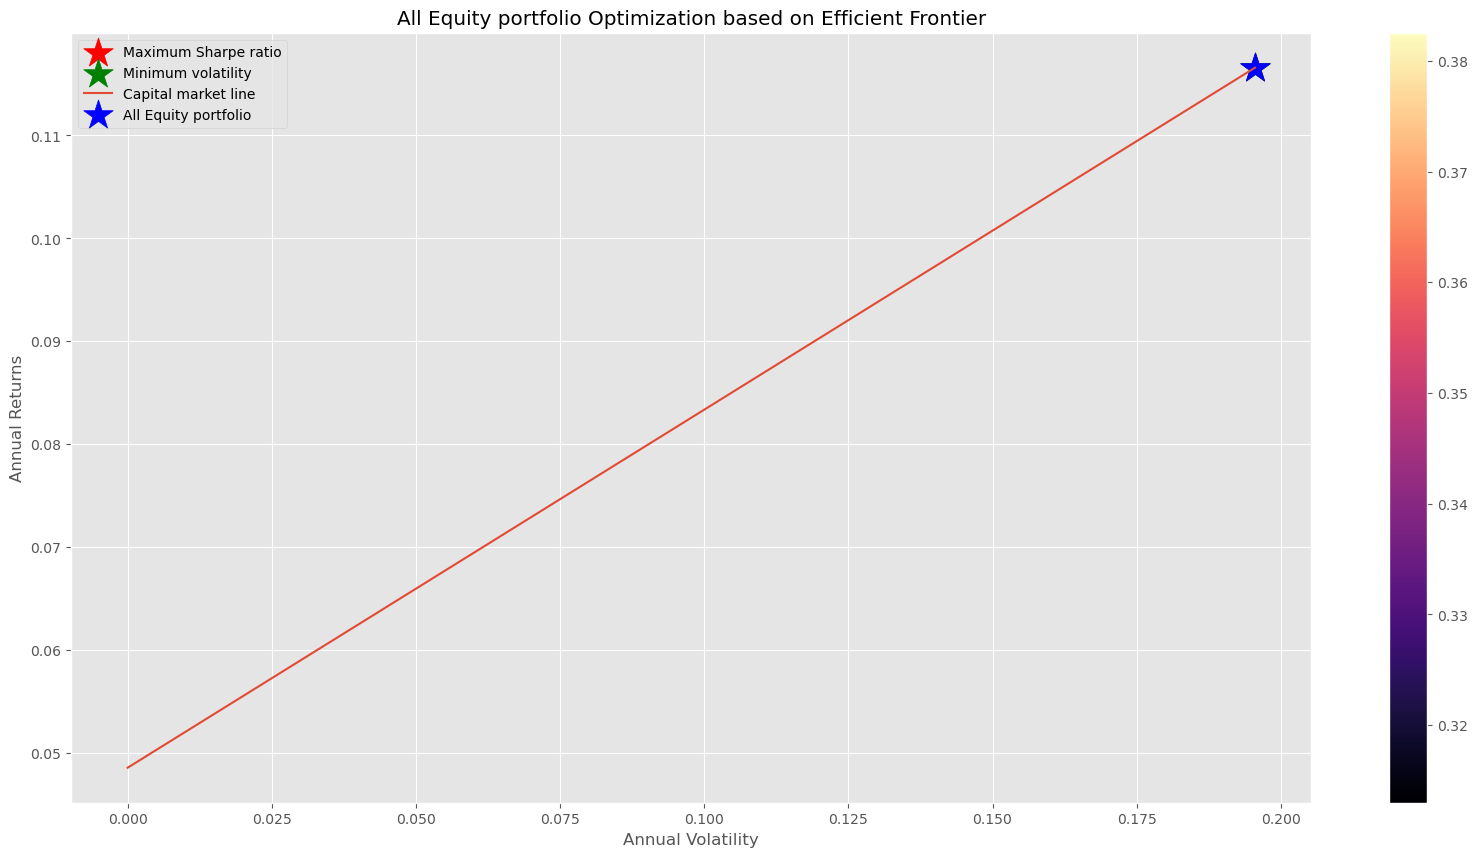

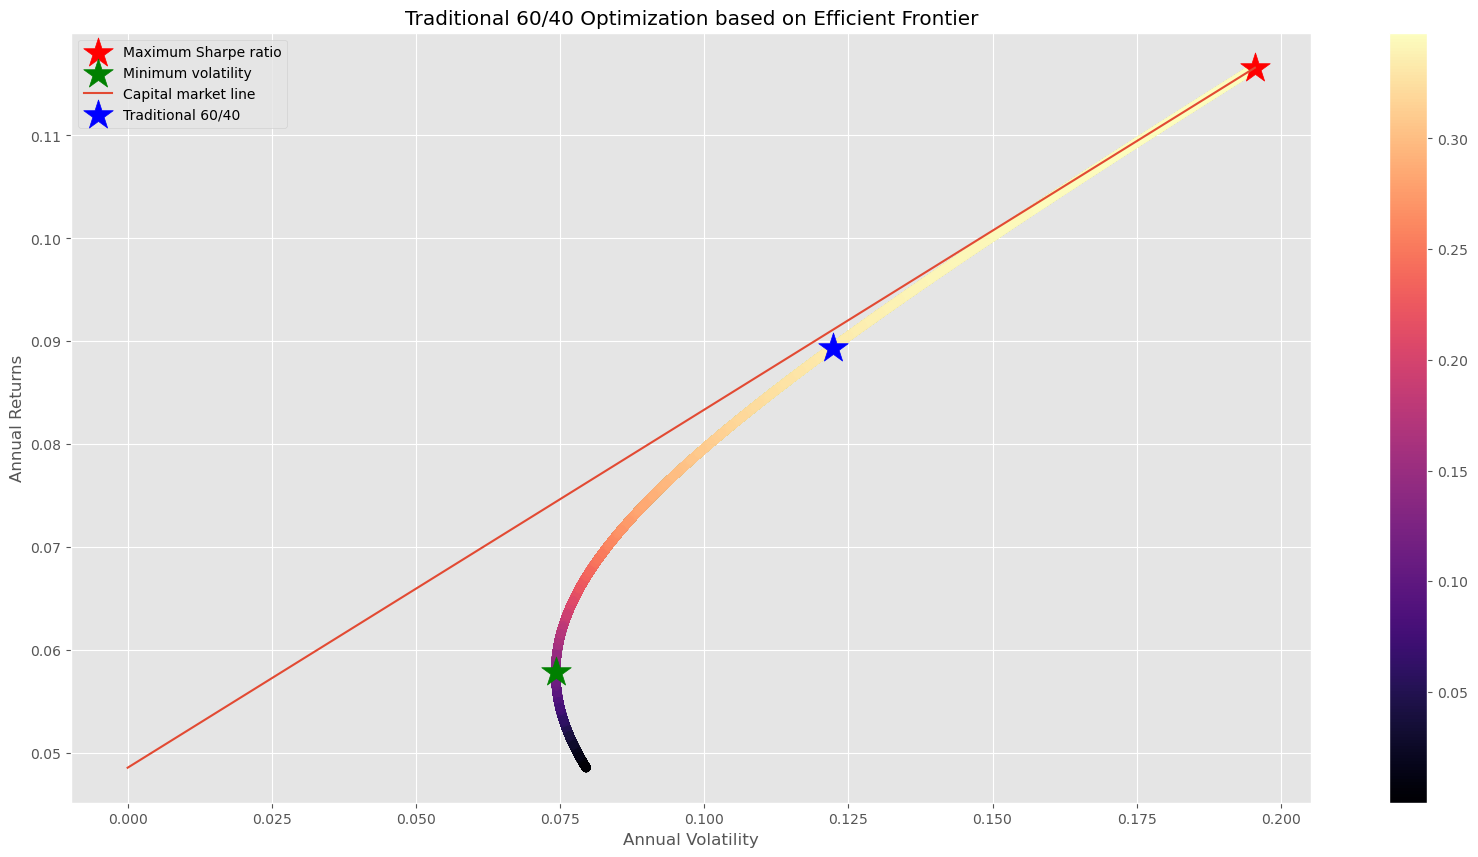

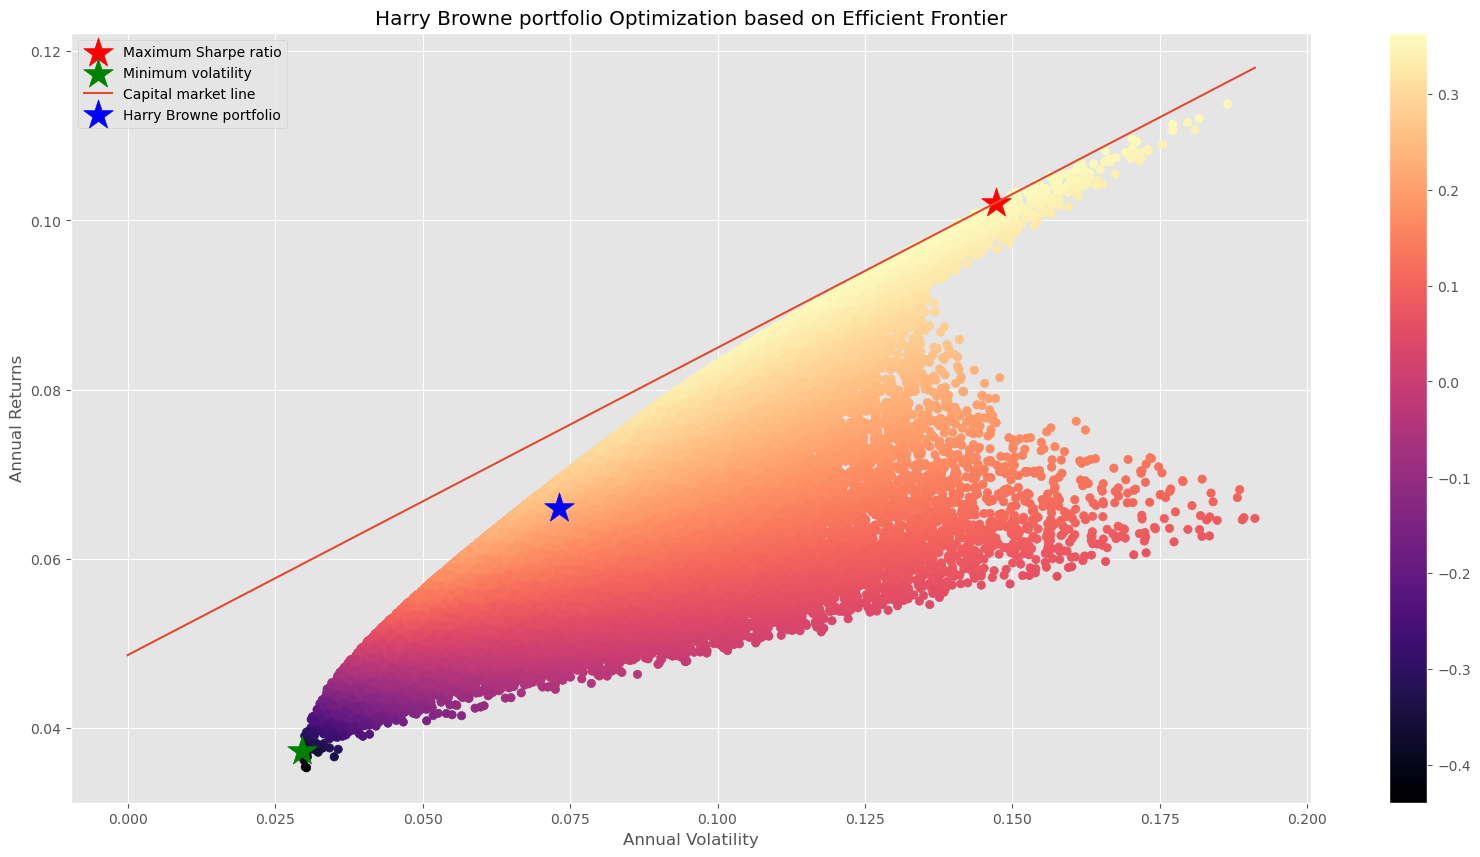

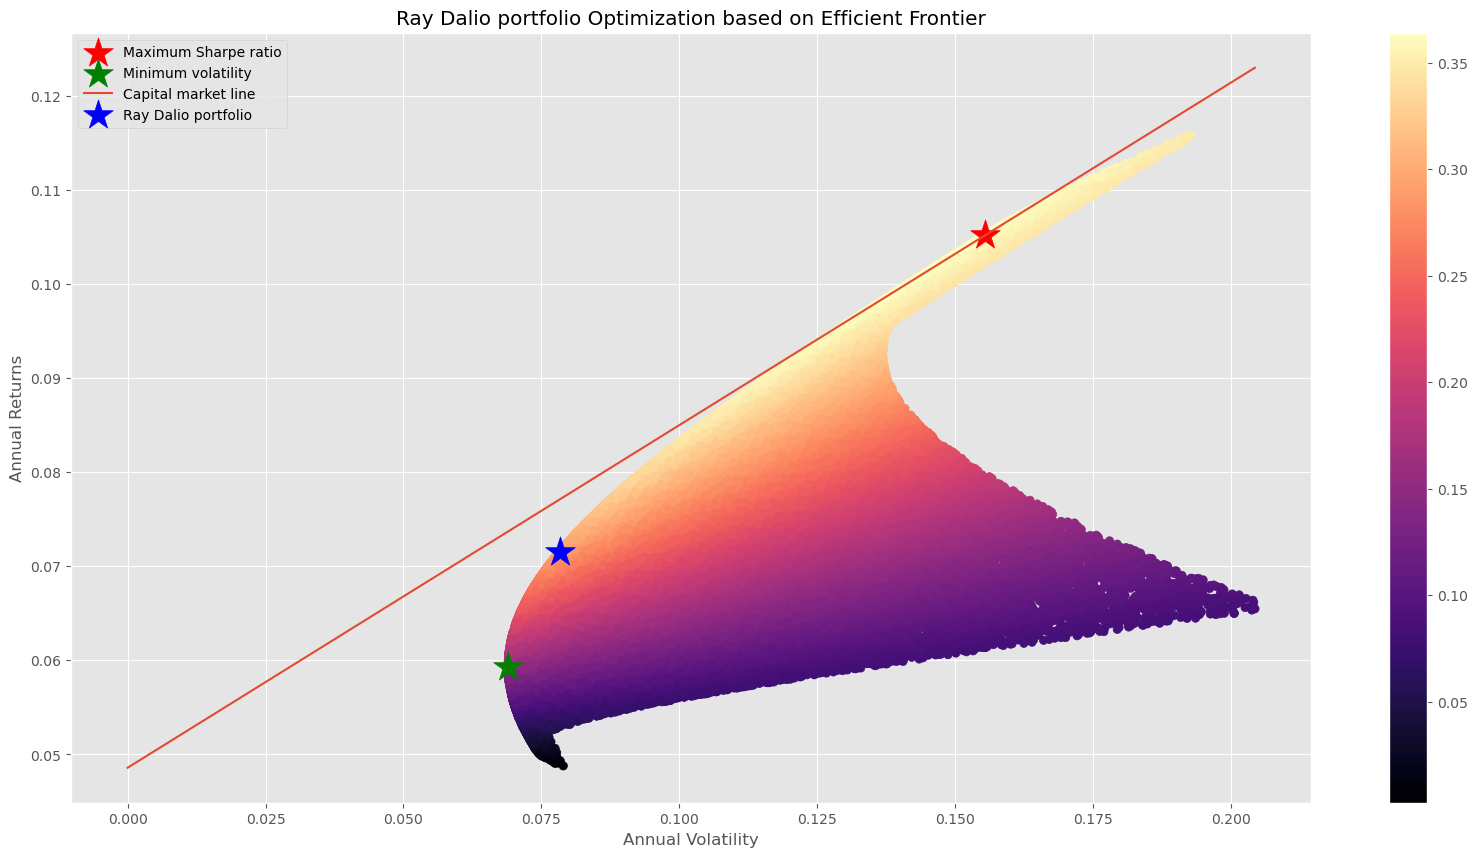

In [19]:
# efficiency of portfolios

asset_dict ={'All Equity portfolio': ['S&P 500'],
             'Traditional 60/40':['S&P 500','T-Bond'],
             'Harry Browne portfolio':['S&P 500', 'T-Bond','T-Bill','Gold'],
             'Ray Dalio portfolio': ['S&P 500', 'T-Bond','Gold']}

for keys, val in  asset_dict.items():
    data = df[val]
    mean_returns = data.mean()
    cov_matrix = data.cov()
    iterations = 100000
    risk_free_rate = df['T-Bond'].mean()
    efficient_frontiers(mean_returns, cov_matrix, iterations, risk_free_rate)
    plt.scatter(summary_stat.loc['std', keys],summary_stat.loc['mean', keys],color = 'blue',marker='*',s=500,label = keys)
    plt.title(keys + ' Optimization based on Efficient Frontier')
    plt.legend()
    plt.show()
    
    
